In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import os
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from torchvision.transforms import ToTensor

from torch.optim import Adam
from torch.nn.modules import MSELoss

%matplotlib inline

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
class CatDataset(Dataset):
    def __init__(self, dataset_abs_path: str):
        super().__init__()
        self.to_tensor = ToTensor()
        self.dataset_abs_path = dataset_abs_path
        self.files = os.listdir(dataset_abs_path)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = self.files[index]
        img_abs_path = os.path.join(self.dataset_abs_path, img)
        img_numpy = plt.imread(img_abs_path)
        img_tensor = self.to_tensor(img_numpy).to(device=device)
        return img_tensor, img_tensor

In [19]:
dataset = CatDataset("./cat_dataset")
data_loader = DataLoader(dataset=dataset, batch_size=32)

In [20]:
class ConvLayers(nn.Module):
    def __init__(
        self,
        img_h,
        img_w,
        in_channels=3,
    ):
        self.img_h = img_h
        self.img_w = img_w
        super().__init__()
        # --- Convolution Layer 1 --- #
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=3, stride=1
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # --- Convolution Layer 2 --- #
        self.conv2 = nn.Conv2d(
            in_channels=self.conv1.out_channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
        )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # --- Convolution Layer 3 --- #
        self.conv3 = nn.Conv2d(
            in_channels=self.conv2.out_channels,
            out_channels=16,
            kernel_size=3,
            stride=1,
        )
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv1_pool_out = self.pool1(conv1_out)

        conv2_out = self.conv2(conv1_pool_out)
        conv2_pool_out = self.pool2(conv2_out)
        conv3_out = self.conv3(conv2_pool_out)
        conv3_pool_out = self.pool3(conv3_out)
        return conv3_pool_out

    # --- Solve for final dimension for Fully Connected Layers ----#
    def get_flatten_dim(self):
        conv1_kh, conv1_kw = self.conv1.kernel_size
        conv1_stride_h, conv1_stride_w = self.conv1.stride
        pool1_kernel = self.pool1.kernel_size
        pool1_stride = self.pool1.stride

        conv1_out_h = math.floor(((self.img_h - conv1_kh) / conv1_stride_h) + 1)
        conv1_out_w = math.floor(((self.img_w - conv1_kw) / conv1_stride_w) + 1)
        pool1_out_h = math.floor(((conv1_out_h - pool1_kernel) / pool1_stride) + 1)
        pool1_out_w = math.floor(((conv1_out_w - pool1_kernel) / pool1_stride) + 1)

        conv2_kh, conv2_kw = self.conv2.kernel_size
        conv2_stride_h, conv2_stride_w = self.conv2.stride
        pool2_kernel = self.pool2.kernel_size
        pool2_stride = self.pool2.stride

        conv2_out_h = math.floor(((pool1_out_h - conv2_kh) / conv2_stride_h) + 1)
        conv2_out_w = math.floor(((pool1_out_w - conv2_kw) / conv2_stride_w) + 1)
        pool2_out_h = math.floor(((conv2_out_h - pool2_kernel) / pool2_stride) + 1)
        pool2_out_w = math.floor(((conv2_out_w - pool2_kernel) / pool2_stride) + 1)

        conv3_kh, conv3_kw = self.conv3.kernel_size
        conv3_stride_h, conv3_stride_w = self.conv3.stride

        pool3_kernel = self.pool3.kernel_size
        pool3_stride = self.pool3.stride

        conv3_out_h = math.floor(((pool2_out_h - conv3_kh) / conv3_stride_h) + 1)
        conv3_out_w = math.floor(((pool2_out_w - conv3_kw) / conv3_stride_w) + 1)
        pool3_out_h = math.floor(((conv3_out_h - pool3_kernel) / pool3_stride) + 1)
        pool3_out_w = math.floor(((conv3_out_w - pool3_kernel) / pool3_stride) + 1)

        return (
            pool3_out_h * pool3_out_w * self.conv3.out_channels,
            (pool3_out_h, pool3_out_w, self.conv3.out_channels),
        )

In [ ]:
class LatentSpace(nn.Module):
    def __init__(self, conv_layers):
        super().__init__()
        flatten_dim, self.dim = conv_layers.get_flatten_dim()
        self.latent_space = nn.Sequential(
            nn.Linear(
                in_features=flatten_dim,
                out_features=(flatten_dim) * 2,
            ),
            nn.Linear(
                in_features=(flatten_dim) * 2,
                out_features=flatten_dim,
            ),
            nn.Linear(
                in_features=flatten_dim,
                out_features=flatten_dim,
            ),
        )

    def forward(self, x):
        out = self.latent_space(x)
        out = out.reshape((32, self.dim[0], self.dim[1], self.dim[2]))
        return out

In [22]:
class ConvTransposedLayers(nn.Module):
    def __init__(self, conv_layers):
        super().__init__()
        # Pool 3
        self.convT1 = nn.ConvTranspose2d(
            in_channels=conv_layers.conv3.out_channels,
            out_channels=conv_layers.conv3.out_channels,
            kernel_size=conv_layers.pool3.kernel_size,
            stride=conv_layers.pool3.stride,
        )
        # Conv 3
        self.convT2 = nn.ConvTranspose2d(
            in_channels=conv_layers.conv3.out_channels,
            out_channels=conv_layers.conv3.in_channels,
            kernel_size=conv_layers.conv3.kernel_size,
            stride=conv_layers.conv3.stride,
        )
        # Pool 2
        self.convT3 = nn.ConvTranspose2d(
            in_channels=conv_layers.conv2.out_channels,
            out_channels=conv_layers.conv2.out_channels,
            kernel_size=conv_layers.pool2.kernel_size,
            stride=conv_layers.pool2.stride,
        )
        # Conv 2
        self.convT4 = nn.ConvTranspose2d(
            in_channels=conv_layers.conv2.out_channels,
            out_channels=conv_layers.conv2.in_channels,
            kernel_size=conv_layers.conv2.kernel_size,
            stride=conv_layers.conv2.stride,
        )
        # Pool 1
        self.convT5 = nn.ConvTranspose2d(
            in_channels=conv_layers.conv1.out_channels,
            out_channels=conv_layers.conv1.out_channels,
            kernel_size=conv_layers.pool1.kernel_size,
            stride=conv_layers.pool1.stride,
            output_padding=1,
        )
        # Conv 1
        self.convT6 = nn.ConvTranspose2d(
            in_channels=conv_layers.conv1.out_channels,
            out_channels=conv_layers.conv1.in_channels,
            kernel_size=conv_layers.conv1.kernel_size,
            stride=conv_layers.conv1.stride,
        )

    def forward(self, x):
        out = self.convT1(x)
        out = self.convT2(out)
        out = self.convT3(out)
        out = self.convT4(out)
        out = self.convT5(out)
        out = self.convT6(out)
        return out

In [ ]:
class CNNAutoEncoder(nn.Module):
    def __init__(
        self,
        img_h,
        img_w,
        in_channels=3,
    ):
        super().__init__()

        self.convs = ConvLayers(img_h=img_h, img_w=img_w, in_channels=in_channels)
        self.flatten = nn.Flatten()
        self.latent_space = LatentSpace(conv_layers=self.convs)
        self.convT = ConvTransposedLayers(conv_layers=self.convs)

    def forward(self, x):
        conv = self.convs(x)
        flatten = self.flatten(conv)
        latent_space = self.latent_space(flatten)
        convT = self.convT(latent_space)
        return convT

In [24]:
model = CNNAutoEncoder(img_h=150, img_w=150).to(device=device)
model

CNNAutoEncoder(
  (convs): ConvLayers(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (latent_space): LatentSpace(
    (latent_space): Sequential(
      (0): Linear(in_features=4096, out_features=8192, bias=True)
      (1): Linear(in_features=8192, out_features=4096, bias=True)
      (2): Linear(in_features=4096, out_features=4096, bias=True)
    )
  )
  (convT): ConvTransposedLayers(
    (convT1): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (convT2): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv

In [25]:
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = MSELoss()

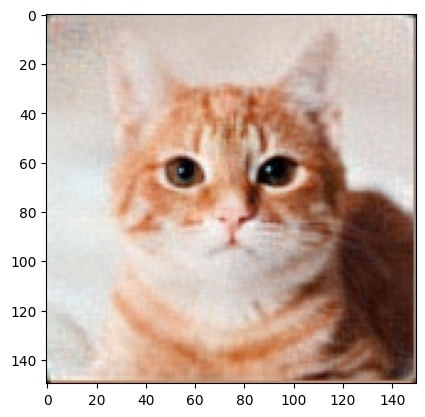

Epoch: 4 | Step: 149 | Loss: 0.001531390124000609


In [26]:
epoch = 5
for e in range(epoch):
    for step, (img, label) in enumerate(data_loader):
        out = model(img)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        img_display = out[1].detach().cpu().permute(1, 2, 0).numpy()
        plt.imshow(img_display)
        clear_output(wait=True)
        plt.pause(0.0001) 
        print(f"Epoch: {e} | Step: {step} | Loss: {loss.item()}")